In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import plotnine as pn
import pickle as pkl
from importlib import reload

import mtg
reload(mtg);

In [3]:
EVAL_MODEL_SAVE_FPATH = '../cache/march292022.bst'
FINAL_MODEL_SAVE_FPATH = '../cache/all_data_march312022.bst'

In [4]:
past_games = mtg.PastGames()

## Training a surrogate over the historical games.
We should actually train many surrogates, and take the average of their preferred decks.

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

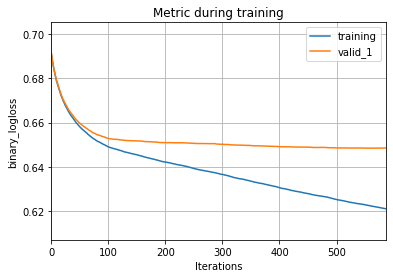

In [5]:
try:
    with open(EVAL_MODEL_SAVE_FPATH, 'rb') as f:
        model = pkl.load(f)    
except FileNotFoundError:
    lgb_params = {'objective': 'binary', 'num_leaves': 32,
                  'l2_lambda': 0.3, 'max_depth': -1}
    model = lgb.LGBMClassifier(**lgb_params, num_boost_round=1000, 
                               random_state=12)
    trn, val = past_games.dsets.sets['trn'], past_games.dsets.sets['val']
    model.fit(**past_games.dsets.sets['trn'], 
              eval_set=[(trn['X'], trn['y']), (val['X'], val['y'])],
              early_stopping_rounds=30)
    with open(EVAL_MODEL_SAVE_FPATH, 'wb') as f:
       pkl.dump(model, f)

pos_idx = np.argmax(model.classes_)
lgb.plot_metric(model)

## Evaluating the surrogate.

In [6]:
y = past_games.dsets.sets['tst']['y']
pred = model.predict_proba(past_games.dsets.sets['tst']['X'])[:, pos_idx]
roc_auc_score(y_true=y, y_score=pred)

0.662191159472389

##### Calibrated?

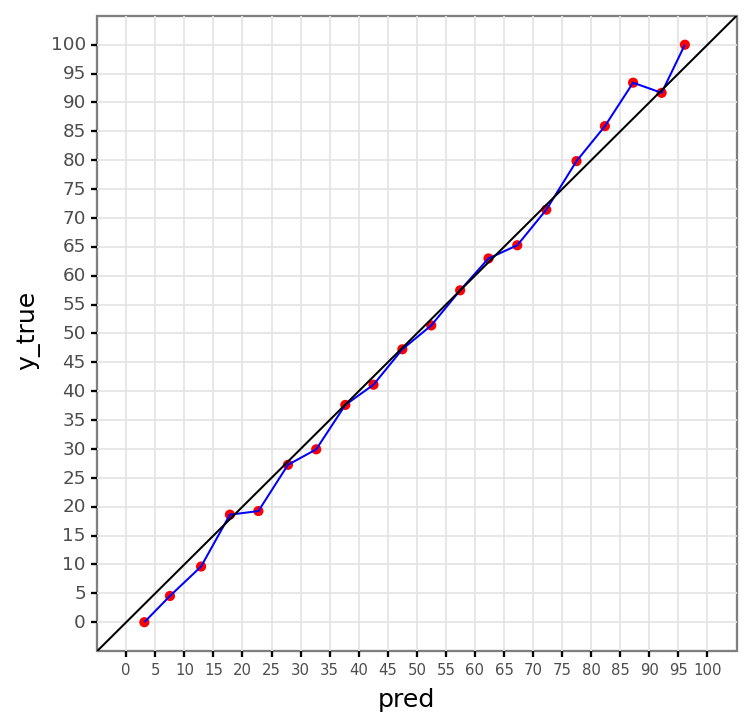

<ggplot: (8753315820737)>

In [7]:
pn.options.dpi = 165
mtg.CalibrationAnalyzer(y, pred).plot

#### Training a model with all the data.

In [8]:
model


LGBMClassifier(l2_lambda=0.3, num_boost_round=1000, num_leaves=32,
               objective='binary', random_state=12)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

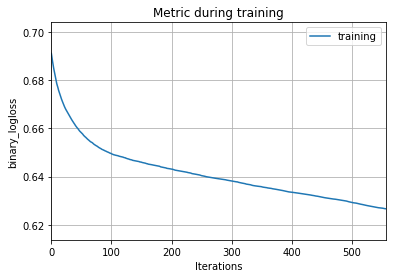

In [9]:
model = past_games.read_or_train_model_all_data(
    FINAL_MODEL_SAVE_FPATH, EVAL_MODEL_SAVE_FPATH)
pos_idx = np.argmax(model.classes_)
lgb.plot_metric(model)

### Seeing which of all possible decks the surrogate favors against the rival's.

In [10]:
rival_deck = mtg.RivalDeck(past_games).deck

In [11]:
possibles = mtg.PossibleDecks(past_games)
decks = possibles.get_decks().sample(frac=1, random_state=16)

In [12]:
deck_defeater = mtg.DeckDefeater(model, decks, rival_deck)
assert (deck_defeater.possible_games.columns == past_games.dsets.sets['trn']['X'].columns).all()
print(f"Mean win probability, possible decks against rival: {deck_defeater.mean_win_proba:.0%}\n\n")
print(f"Best deck:\n{deck_defeater.best_deck_str}")

Mean win probability, possible decks against rival: 41%


Best deck:
Alessin_Adamant_Angel_Deck_A_Count: 3
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 0
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 0
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 0
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 0
Murderous_Minotaur_Deck_A_Count: 1
Patchy_Pirate_Deck_A_Count: 6
Sword_of_Shadows_Deck_A_Count: 2
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 71%


In [13]:
deck_defeater = mtg.DeckDefeater(model, decks, rival_deck)
assert (deck_defeater.possible_games.columns == past_games.dsets.sets['trn']['X'].columns).all()
print(f"Mean win probability, possible decks against rival: {deck_defeater.mean_win_proba:.0%}\n\n")
print(f"Best deck:\n{deck_defeater.best_deck_str}")

Mean win probability, possible decks against rival: 41%


Best deck:
Alessin_Adamant_Angel_Deck_A_Count: 3
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 0
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 0
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 0
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 0
Murderous_Minotaur_Deck_A_Count: 1
Patchy_Pirate_Deck_A_Count: 6
Sword_of_Shadows_Deck_A_Count: 2
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 71%


In [14]:
rival_deck

,Alessin_Adamant_Angel_Deck_B_Count,Bold_Battalion_Deck_B_Count,Dreadwing_Darkfire_Dragon_Deck_B_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_B_Count,Gentle_Guard_Deck_B_Count,Horrible_Hooligan_Deck_B_Count,Kindly_Knight_Deck_B_Count,Lilac_Lotus_Deck_B_Count,Murderous_Minotaur_Deck_B_Count,Patchy_Pirate_Deck_B_Count,Sword_of_Shadows_Deck_B_Count,Virtuous_Vigilante_Deck_B_Count
0,1,1,1,1,1,1,1,1,1,1,1,1


In [15]:
best_deck_against_rival = (
    past_games.deck_from_game_id('_'.join(
        [str(x) for x in [3,0,0,0,0,0,0,0,1,6,2,0]])))
best_deck_against_rival.columns = [
    c + '_Deck_A_Count' for c in best_deck_against_rival.columns]
model.predict_proba(pd.concat([best_deck_against_rival, rival_deck], axis=1))

array([[0.28922517, 0.71077483]])

## Choosing decks for competitive play.
Strategies; we could choose the best... :
* whole-universe-generalist deck: the deck that performs best against all possible decks.
* actual-universe-generalist deck: the deck that performs best against all decks in the input data.
* whole-universe-counter deck: the deck that performs best against the whole-universe generalist deck.
* actual-universe-counter deck
* And so on, down the levels of recursion.
* Alternatively, the whole-universe-part-generalist-part-counter deck: 
a deck in-between  
the whole-universe-generalist deck 
and the whole-universe-counter deck.
* actual-universe-part-generalist-part-counter deck
* More?

#### Finding the whole-universe-generalist deck.

In [24]:
whole_universe_scorer = mtg.GameScorer(decks, model, 'whole_universe')
# whole_universe_scorer.score_chunks(4, 100000)

In [16]:
actual_universe_scorer = mtg.GameScorer(
    past_games.decksA.copy(), model, 'actual_universe_all_data')
actual_universe_scorer.score_chunks(16, 100000)

In [26]:
au_best_deck = past_games.deck_from_game_id(actual_universe_scorer.best_deck)
wu_best_deck = past_games.deck_from_game_id(whole_universe_scorer.best_deck)

In [27]:
def print_score(scorer, deck):
    deck_score = scorer.score_deck(deck).iloc[0]
    print(f"{deck_score['game_id']}, {deck_score['p_avg']:.4f}")


print_score(whole_universe_scorer, au_best_deck)
print_score(actual_universe_scorer, au_best_deck)
print()

print_score(whole_universe_scorer, wu_best_deck)
print_score(actual_universe_scorer, wu_best_deck)

3_0_0_0_0_0_0_0_0_4_5_0, 0.7505
3_0_0_0_0_0_0_0_0_4_5_0, 0.7506

6_0_1_0_0_0_0_4_0_0_0_1, 0.7489
6_0_1_0_0_0_0_4_0_0_0_1, 0.7490


In [61]:
[(card, count) for card, count in zip(au_best_deck.columns, au_best_deck.iloc[0]) if count > 0]

[('Alessin_Adamant_Angel_Deck_B_Count', 3),
 ('Patchy_Pirate_Deck_B_Count', 4),
 ('Sword_of_Shadows_Deck_B_Count', 5)]

In [58]:
past_games.deck_from_game_id(au_best_deck['game_id'])

KeyError: 'game_id'

#### Countering the generalist decks.
Now that we know the best universal deck is `au_best_deck`, can we find a deck that does well
against it & decks like it, but also does well against the universe? (It's OK to use the actual universe for this). 

In [28]:
decks

,Alessin_Adamant_Angel_Deck_A_Count,Bold_Battalion_Deck_A_Count,Dreadwing_Darkfire_Dragon_Deck_A_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count,Gentle_Guard_Deck_A_Count,Horrible_Hooligan_Deck_A_Count,Kindly_Knight_Deck_A_Count,Lilac_Lotus_Deck_A_Count,Murderous_Minotaur_Deck_A_Count,Patchy_Pirate_Deck_A_Count,Sword_of_Shadows_Deck_A_Count,Virtuous_Vigilante_Deck_A_Count,game_id
73187,0,1,1,2,0,0,0,3,1,1,3,0,0_1_1_2_0_0_0_3_1_1_3_0
817538,2,0,1,1,1,2,1,1,0,0,3,0,2_0_1_1_1_2_1_1_0_0_3_0
1324738,2,0,1,1,0,1,2,1,0,0,0,4,2_0_1_1_0_1_2_1_0_0_0_4
1171982,1,0,2,0,0,2,0,3,0,1,2,1,1_0_2_0_0_2_0_3_0_1_2_1
922009,0,1,0,2,0,0,0,4,4,0,0,1,0_1_0_2_0_0_0_4_4_0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823748,4,0,0,1,4,0,0,0,0,0,1,2,4_0_0_1_4_0_0_0_0_0_1_2
98939,0,2,1,1,2,1,1,0,4,0,0,0,0_2_1_1_2_1_1_0_4_0_0_0
98885,2,0,5,1,0,0,2,0,0,2,0,0,2_0_5_1_0_0_2_0_0_2_0_0
919673,1,0,0,0,1,4,2,0,2,0,1,1,1_0_0_0_1_4_2_0_2_0_1_1


In [33]:
au_best_deck

,Alessin_Adamant_Angel_Deck_B_Count,Bold_Battalion_Deck_B_Count,Dreadwing_Darkfire_Dragon_Deck_B_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_B_Count,Gentle_Guard_Deck_B_Count,Horrible_Hooligan_Deck_B_Count,Kindly_Knight_Deck_B_Count,Lilac_Lotus_Deck_B_Count,Murderous_Minotaur_Deck_B_Count,Patchy_Pirate_Deck_B_Count,Sword_of_Shadows_Deck_B_Count,Virtuous_Vigilante_Deck_B_Count
0,3,0,0,0,0,0,0,0,0,4,5,0


In [44]:
dropcols = [c for c in decks.columns if 'game_id' in c]
generalist_defeater = mtg.DeckDefeater(
    model, decks.drop(dropcols, axis=1), au_best_deck)
print(f"Mean win probability, possible decks against best generalist deck: "
      f"{generalist_defeater.mean_win_proba:.2%}\n")
print(f"{generalist_defeater.best_deck_str}")


Mean win probability, possible decks against best generalist deck: 20.14%

Alessin_Adamant_Angel_Deck_A_Count: 6
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 1
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 1
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 0
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 4
Murderous_Minotaur_Deck_A_Count: 0
Patchy_Pirate_Deck_A_Count: 0
Sword_of_Shadows_Deck_A_Count: 0
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 56%


In [55]:
decks

,Alessin_Adamant_Angel_Deck_A_Count,Bold_Battalion_Deck_A_Count,Dreadwing_Darkfire_Dragon_Deck_A_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count,Gentle_Guard_Deck_A_Count,Horrible_Hooligan_Deck_A_Count,Kindly_Knight_Deck_A_Count,Lilac_Lotus_Deck_A_Count,Murderous_Minotaur_Deck_A_Count,Patchy_Pirate_Deck_A_Count,Sword_of_Shadows_Deck_A_Count,Virtuous_Vigilante_Deck_A_Count,game_id_Deck_A_Count
73187,0,1,1,2,0,0,0,3,1,1,3,0,0_1_1_2_0_0_0_3_1_1_3_0
817538,2,0,1,1,1,2,1,1,0,0,3,0,2_0_1_1_1_2_1_1_0_0_3_0
1324738,2,0,1,1,0,1,2,1,0,0,0,4,2_0_1_1_0_1_2_1_0_0_0_4
1171982,1,0,2,0,0,2,0,3,0,1,2,1,1_0_2_0_0_2_0_3_0_1_2_1
922009,0,1,0,2,0,0,0,4,4,0,0,1,0_1_0_2_0_0_0_4_4_0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823748,4,0,0,1,4,0,0,0,0,0,1,2,4_0_0_1_4_0_0_0_0_0_1_2
98939,0,2,1,1,2,1,1,0,4,0,0,0,0_2_1_1_2_1_1_0_4_0_0_0
98885,2,0,5,1,0,0,2,0,0,2,0,0,2_0_5_1_0_0_2_0_0_2_0_0
919673,1,0,0,0,1,4,2,0,2,0,1,1,1_0_0_0_1_4_2_0_2_0_1_1


In [56]:
dropcols = [c for c in decks.columns if 'game_id' in c]
defeater_of_defeater = mtg.DeckDefeater(
    model, decks.drop(dropcols, axis=1), generalist_defeater.best_deck)
print(f"Mean win probability, possible decks against best generalist deck: "
      f"{defeater_of_defeater.mean_win_proba:.2%}\n")
print(f"{defeater_of_defeater.best_deck_str}")


Mean win probability, possible decks against best generalist deck: 28.80%

Alessin_Adamant_Angel_Deck_A_Count: 3
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 0
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 0
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 0
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 0
Murderous_Minotaur_Deck_A_Count: 1
Patchy_Pirate_Deck_A_Count: 4
Sword_of_Shadows_Deck_A_Count: 4
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 78%


In [ ]:
# Could we code up or use a gradient descent package 
# that helps us search deck-space?
# It would be implemented for every possible Deck A,
# to search a subspace of the possible deck B's.
# You don't have to explicitly generate the deck B's
# to get recommendations on items from deck B; instead, 
# let the algorithm tell you the deck B to look at next,
# via some alpha-step, or furthest-from-all-so-far, algorithm.
# It will give you continuous entries but you can just round them.

##

# We don't need to look at all possible matches
# to search deck-A-space efficiently - since we're interested in average
# performance against all possible deck B's, we're only searching through
# variations on deck A.
# 
# That means we can use a further-from-points-I've-searched-so-far strategy to sample points from
# deck-A-space. Cuz deck A is small enough that we can embed it and find distances in it. 

## Analyzing the structure of deck-space.

## Analyzing the structure of matchups-space.